In [31]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import integrate
from scipy import interpolate
import math
from scipy import signal
%run StreamClassReader.ipynb

## Plot each variable on a graph

In [33]:
data = Data_Stream("data5.csv")
print(data.acc_DRC.shape)
# data.plot()

Parsed File
Interpolated Samples
Rotated Acceleration
Integrated Acceleration
(4760, 4)


## Perform butterworth low pass filtering, re integrate data and plot
Frequency cutoff value is just an estimate

In [5]:
data = Data_Stream("data5.csv")
def filter_acc(times, acc, T, fs, plot=False):
    fs = data.frequency  # Sampling frequency
    fc = 1  # Cut-off frequency of the filter
    w = fc / (fs / 2) # Normalize the frequency

    b, a = signal.butter(3, w, 'low') ##W is between 1 and 0, 1 is a perfect reconstruction, ie shannon nyquist

    output = signal.filtfilt(b, a, acc.T)
    if(plot):
        plt.figure(figsize=(15, 6))
        ax=plt.subplot(111)
        plt.plot(times, acc, label='X')
        plt.plot(times, output.T, label='filtered')
        plt.legend()
        plt.show()
    return output.T


data.acc_ERC[:, 1] = filter_acc(data.acc_ERC[:, 0], data.acc_ERC[:, 1], data.time_period, data.frequency)
data.acc_ERC[:, 2] = filter_acc(data.acc_ERC[:, 0], data.acc_ERC[:, 2], data.time_period, data.frequency)
data.acc_ERC[:, 3] = filter_acc(data.acc_ERC[:, 0], data.acc_ERC[:, 3], data.time_period, data.frequency)

data.acc_DRC[:, 1] = filter_acc(data.acc_DRC[:, 0], data.acc_DRC[:, 1], data.time_period, data.frequency)
data.acc_DRC[:, 2] = filter_acc(data.acc_DRC[:, 0], data.acc_DRC[:, 2], data.time_period, data.frequency)
data.acc_DRC[:, 3] = filter_acc(data.acc_DRC[:, 0], data.acc_DRC[:, 3], data.time_period, data.frequency)



Parsed File
Interpolated Samples
Rotated Acceleration
Integrated Acceleration


/home/hw16471/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [34]:
data.integrate_variables()
# data.plot()


## Kalman Filter Implementation

In [35]:
def getQ(acc_stddev, dt):
    vel_stddev = acc_stddev*dt
    dis_stddev = 0.5*acc_stddev*dt**2
    Q = (dis_stddev**2)*np.identity(4)
    Q[2, 2] = vel_stddev**2
    Q[3, 3] = vel_stddev**2
    Q[0, 2] = dis_stddev*vel_stddev
    Q[1, 3] = dis_stddev*vel_stddev
    return Q

def getFkBk(Fk, Bk, dt):
    Fk[0, 2] = dt
    Fk[1, 3] = dt
    Bk[0, 0] = 0.5*dt**2
    Bk[1, 1] = 0.5*dt**2
    Bk[2, 0] = dt
    Bk[3, 1] = dt
    return Fk, Bk

def kalman_predict(dt, Fk, Bk, xk, uk, Pk, acc_stddev):
    Q = getQ(acc_stddev, dt)
    Fk, Bk = getFkBk(Fk, Bk, dt)
    xk = np.matmul(Fk, xk) + np.matmul(Bk, uk)
    Pk = np.matmul(np.matmul(Fk, Pks[-1]), Fk.T) + Q
    return xk, Pk, Fk, Bk

def kalman_gain(Pk, H, R):
    PkHT = np.matmul(Pk, H.T)
    K = np.matmul(PkHT, np.linalg.inv(np.matmul(H, PkHT)+R))
    return K

def kalman_update_state(xk, zk, K, H):
    Hxk = np.matmul(H, xk)
    zk = np.concatenate((zk, np.asmatrix([0])))
    zk = np.concatenate((zk, np.asmatrix([0])))
    return xk+np.matmul(K, zk-Hxk )

def kalman_update_uncertainty(Pk, K, H):
    return Pk - np.matmul(K, np.matmul(H, Pk))

In [36]:
data = Data_Stream("data5.csv")

## Assume that the initial state is position (0, 0) and velocity (0, 0)
x0 = np.asmatrix([0, 0, 0, 0]).T
xks = [x0]
u0 = data.acc_ERC[0, 1:3].T
uks = [u0]
Fk = np.asmatrix(np.identity(4))
Bk = np.zeros((4, 2))

acc_stddev = 0.6

P0 = np.zeros((4, 4))
Pks = [P0]

H = np.identity(4)
H[2, 2] = 0.0
H[3, 3] = 0.0
gps_var = 15.2
R = gps_var*np.identity(4)


for i in range(1, data.acc_DRC.shape[0]):
    dt = data.acc_DRC[i, 0] - data.acc_DRC[i-1, 0]
    xk, Pk, Fk, Bk = kalman_predict(dt, Fk, Bk, xks[-1], uks[-1], Pks[-1], acc_stddev)
    xks.append(xk)
    uks.append(data.acc_ERC[i, 1:3].T)
    Pks.append(Pk)
    zk = data.gps[i, 1:3].T
    
    K = kalman_gain(Pks[-1], H, R)
    xks[-1] = kalman_update_state(xk, zk, K, H)
    Pks[-1] = kalman_update_uncertainty(Pks[-1], K, H)
       
    
xks = [xk.T for xk in xks]
xks = np.concatenate(xks)
data.init_kalman(xks)


FileNotFoundError: [Errno 2] No such file or directory: 'Data/streams/Data/data5.csv'

Plot Kalman Filter output against original Sensor Input

Text(0.5, 1.0, 'Velocity Y (Integration of Uncorrected Acceleration)')

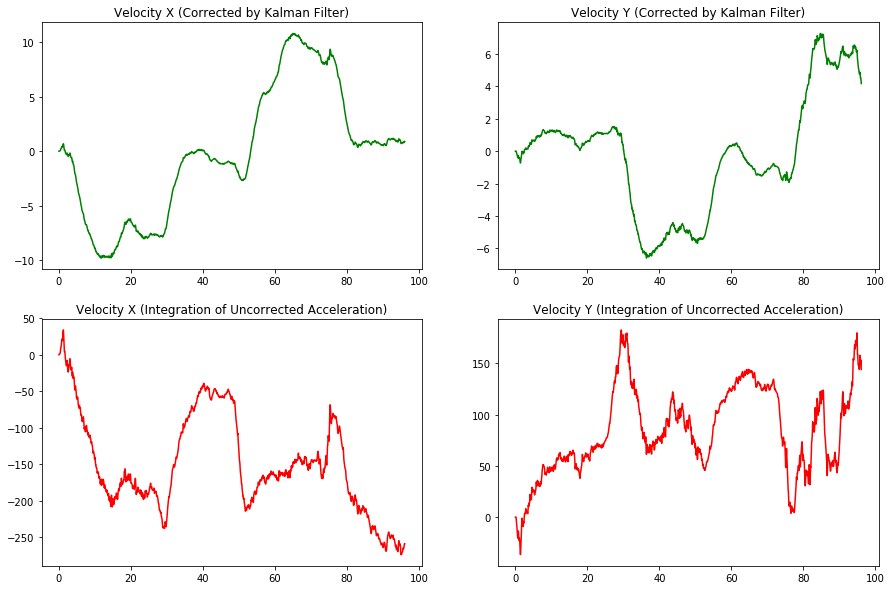

In [14]:
plt.figure(figsize=(15, 10))
ax=plt.subplot(221)
# plt.plot(data.vel_ERC[:, 0], data.vel_ERC[:, 1], 'r-')
plt.plot(data.vel_ERC[:, 0], xks[:, 2], 'g-')
plt.title("Velocity X (Corrected by Kalman Filter)")


ax=plt.subplot(222)
# plt.plot(data.vel_ERC[:, 0], data.vel_ERC[:, 2], 'r-')
plt.plot(data.vel_ERC[:, 0], xks[:, 3], 'g-')
plt.title("Velocity Y (Corrected by Kalman Filter)")


ax=plt.subplot(223)
plt.plot(data.vel_ERC[:, 0], data.vel_ERC[:, 1], 'r-', )
plt.title("Velocity X (Integration of Uncorrected Acceleration)")


ax=plt.subplot(224)
plt.plot(data.vel_ERC[:, 0], data.vel_ERC[:, 2], 'r-')
plt.title("Velocity Y (Integration of Uncorrected Acceleration)")


In [15]:
##Do GMAPS Python Plotting 
##https://www.geeksforgeeks.org/python-plotting-google-map-using-gmplot-package/

## Plotting Overlay on Google Maps
https://www.geeksforgeeks.org/python-plotting-google-map-using-gmplot-package/

https://github.com/pbugnion/gmaps

https://jupyter-gmaps.readthedocs.io/en/latest/

In [16]:
import gmaps
import gmaps.datasets

f = open('apikey.txt')
a = f.readline()

gmaps.configure(api_key=a) # Your Google API key

f_layout = {'width': '900px','height': '800px','border': '1px solid black', 'padding': '1px'}
fig = gmaps.figure(layout = f_layout, center=(data.kal_latlng[0, 2], 
                                              data.kal_latlng[0, 1]), zoom_level=18, map_type='HYBRID')
lines = []

locations_kal = gmaps.heatmap_layer([(i[0, 2], i[0, 1]) for i in data.kal_latlng])
locations_kal.gradient = [(0, 0, 0, 0.0), (0, 255, 0, 1), (0, 128, 0, 1)]
locations_kal.max_intensity = 20
locations_kal.point_radius = 5

locations_gps = gmaps.heatmap_layer([(i[0, 2], i[0, 1]) for i in data.gps_latlng])
locations_gps.gradient = [(0, 0, 0, 0.0), (255, 0, 0, 1), (128, 0, 0 , 1)]
locations_gps.max_intensity = 20
locations_gps.point_radius = 5

In [17]:
fig.add_layer(locations_kal)
fig.add_layer(locations_gps)
fig

Figure(layout=FigureLayout(border='1px solid black', height='800px', padding='1px', width='900px'))